In [1]:
import probe_lm
from probe_lm import data_utils
from probe_lm import plotting_utils, metrics

import matplotlib.pyplot as plt
#plt.style.use('dark_background') # for viewing in notebook
plt.style.use('default') # for production of plots for paper/quip

%load_ext autoreload
%autoreload 2
from transformers import GPT2Model, GPT2Config
from transformers import GPT2Tokenizer
from transformers import GPT2LMHeadModel
from tabulate import tabulate

import numpy as np
import pickle

import seaborn as sns
sns.set_theme()

import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from probe_lm import data_utils, normalize_dict, plotting_utils, compute_metrics



/opt/conda/envs/renate_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load prompts and ground truth

In [2]:
# read list of basic prompts to extend automatically
basic_prompts = data_utils.read_prompts("../data/population-prompts-automatic.txt")
extended_prompts = data_utils.extend_prompt_list(basic_prompts)
# run this twice in order to produce all combinations of pronouns + relations
extended_prompts = data_utils.extend_prompt_list(extended_prompts)

ground_truth_file = "../data/english-speaking-population-data.txt"
ground_truth = data_utils.read_population_data(ground_truth_file)
ground_truth = probe_lm.normalize_dict(ground_truth)

len(basic_prompts), len(extended_prompts)

(64, 955)

### Models under consideration

In [3]:
model_types_gpt2 = ['gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl']
model_types_gpt_neo = ["gpt-neo-125M", "gpt-neo-1.3B", "gpt-neo-2.7B"]
model_types_llama = ['open_llama_3b', 'open_llama_7b']

## Load and preprocess Pile data

In [4]:
pile_df = pd.read_csv('../data/pile-country-counts-adjusted.csv')
pile_df.drop(84, inplace=True) # metadata
pile_df.drop(119, inplace=True) # more metadata
pile_df.loc[117, 'country_generic'] = 'the u.s. virgin islands' # make naming consistent with ground truth
pile_data = {row[1]['country_generic']: float(row[1]['counts']) for row in pile_df.iterrows()}
pile_data_normalised = normalize_dict(pile_data)
# adjust spelling to ground truth
countries = pile_data_normalised.copy().keys()
for country1 in countries:
    for country2 in ground_truth.keys():
        if country1 == country2.lower():
            pile_data_normalised[country2] = pile_data_normalised[country1]
            del pile_data_normalised[country1]

## Load predictions

In [1]:
# all predictions
with open('../results/results_disambiguated_paper/geography_prompt_predictions_gpt2.p', 'rb') as file:
    all_predictions_gpt2small = pickle.load(file) # already normalised
with open('../results/results_disambiguated_paper/geography_prompt_predictions_gpt2-medium.p', 'rb') as file:
    all_predictions_gpt2medium = pickle.load(file) # already normalised
with open('../results/results_disambiguated_paper/geography_prompt_predictions_gpt2-large.p', 'rb') as file:
    all_predictions_gpt2large = pickle.load(file) # already normalised
with open('../results/results_disambiguated_paper/geography_prompt_predictions_gpt2-xl.p', 'rb') as file:
     all_predictions_gpt2xl = pickle.load(file) # already normalised
with open('../results/results_disambiguated_paper/geography_prompt_predictions_gpt-neo-125M.p', 'rb') as file:
    all_predictions_gptneosmall = pickle.load(file) # already normalised
with open('../results/results_disambiguated_paper/geography_prompt_predictions_gpt-neo-1.3B.p', 'rb') as file:
    all_predictions_gptneomedium = pickle.load(file) # already normalised
with open('../results/results_disambiguated_paper/geography_prompt_predictions_gpt-neo-2.7B.p', 'rb') as file:
    all_predictions_gptneolarge = pickle.load(file) # already normalised
with open('../results/results_disambiguated_paper/geography_prompt_predictions_gpt-neox-20b.p', 'rb') as file:
    all_predictions_gptneoxl = pickle.load(file) # already normalised
with open('../results/results_disambiguated_paper/geography_prompt_predictions_open_llama_3b.p', 'rb') as file:
    all_predictions_llama3b = pickle.load(file) # already normalised
with open('../results/results_disambiguated_paper/geography_prompt_predictions_open_llama_7b.p', 'rb') as file:
    all_predictions_llama7b = pickle.load(file) # already normalised
     
# aggregated predictions
with open('../results/results_disambiguated_paper/geography_aggregated_predictions_gpt2.p', 'rb') as file:
    aggregated_predictions_gpt2small = pickle.load(file) # already normalised
with open('../results/results_disambiguated_paper/geography_aggregated_predictions_gpt2-medium.p', 'rb') as file:
    aggregated_predictions_gpt2medium = pickle.load(file) # already normalised
with open('../results/results_disambiguated_paper/geography_aggregated_predictions_gpt2-large.p', 'rb') as file:
    aggregated_predictions_gpt2large = pickle.load(file) # already normalised
with open('../results/results_disambiguated_paper/geography_aggregated_predictions_gpt2-xl.p', 'rb') as file:
    aggregated_predictions_gpt2xl = pickle.load(file) # already normalised
with open('../results/results_disambiguated_paper/geography_aggregated_predictions_gpt-neo-125M.p', 'rb') as file:
    aggregated_predictions_gptneosmall = pickle.load(file) # already normalised
with open('../results/results_disambiguated_paper/geography_aggregated_predictions_gpt-neo-1.3B.p', 'rb') as file:
    aggregated_predictions_gptneomedium = pickle.load(file) # already normalised
with open('../results/results_disambiguated_paper/geography_aggregated_predictions_gpt-neo-2.7B.p', 'rb') as file:
    aggregated_predictions_gptneolarge = pickle.load(file) # already normalised
with open('../results/results_disambiguated_paper/geography_aggregated_predictions_gpt-neox-20b.p', 'rb') as file:
    aggregated_predictions_gptneox= pickle.load(file) # already normalised
with open('../results/results_disambiguated_paper/geography_aggregated_predictions_open_llama_3b.p', 'rb') as file:
    aggregated_predictions_llama3b = pickle.load(file) # already normalised
with open('../results/results_disambiguated_paper/geography_aggregated_predictions_open_llama_7b.p', 'rb') as file:
    aggregated_predictions_llama7b = pickle.load(file) # already normalised

NameError: name 'pickle' is not defined

In [6]:
gpt2 = [all_predictions_gpt2small, all_predictions_gpt2medium, all_predictions_gpt2large, all_predictions_gpt2xl]
gpt2_sizes =[117, 345, 774, 1558]
gpt2_neo = [all_predictions_gptneosmall, all_predictions_gptneomedium, all_predictions_gptneolarge, all_predictions_gptneoxl]
gpt_neo_sizes = [125, 1315, 2700, 20000]
llama  = [all_predictions_llama3b, all_predictions_llama7b]
llama_sizes = [3000, 7000]
gpt_neo_sizes = [125, 1315, 2700, 20000]
all_sizes = sorted(gpt2_sizes + gpt_neo_sizes + llama_sizes)

In [7]:
gpt2_EBrs = []
gpt_neo_EBrs = []
llama_EBrs = []

for predictions in gpt2:
    ground_truth_EBr, erasure_set_sizes =  metrics.compute_metrics(predictions, ground_truth, use_erasure_set=True, r=3)
    gpt2_EBrs.append(ground_truth_EBr)

for predictions in gpt2_neo:
    ground_truth_EBr, erasure_set_sizes =  metrics.compute_metrics(predictions, ground_truth, use_erasure_set=True, r=3)
    gpt_neo_EBrs.append(ground_truth_EBr)
    
for predictions in llama:
    ground_truth_EBr, erasure_set_sizes =  metrics.compute_metrics(predictions, ground_truth, use_erasure_set=True, r=3)
    llama_EBrs.append(ground_truth_EBr)

In [8]:
aggregated_gpt2small_EBr, _ =  metrics.compute_metrics([aggregated_predictions_gpt2small], ground_truth, use_erasure_set=True, r=3)
aggregated_gpt2medium_EBr, _ =  metrics.compute_metrics([aggregated_predictions_gpt2medium], ground_truth, use_erasure_set=True, r=3)
aggregated_gpt2large_EBr, _ =  metrics.compute_metrics([aggregated_predictions_gpt2large], ground_truth, use_erasure_set=True, r=3)
aggregated_gpt2xl_EBr, _ =  metrics.compute_metrics([aggregated_predictions_gpt2xl], ground_truth, use_erasure_set=True, r=3)

aggregated_gptneosmall_EBr, _ =  metrics.compute_metrics([aggregated_predictions_gptneosmall], ground_truth, use_erasure_set=True, r=3)
aggregated_gptneomedium_EBr, _ =  metrics.compute_metrics([aggregated_predictions_gptneomedium], ground_truth, use_erasure_set=True, r=3)
aggregated_gptneolarge_EBr, _ =  metrics.compute_metrics([aggregated_predictions_gptneolarge], ground_truth, use_erasure_set=True, r=3)
aggregated_gptneox_EBr, _ =  metrics.compute_metrics([aggregated_predictions_gptneox], ground_truth, use_erasure_set=True, r=3)

aggregated_llama3b_EBr, _ =  metrics.compute_metrics([aggregated_predictions_llama3b], ground_truth, use_erasure_set=True, r=3)
aggregated_llama7b_EBr, _ =  metrics.compute_metrics([aggregated_predictions_llama7b], ground_truth, use_erasure_set=True, r=3)

aggregated_gptneox_EBr


[0.4568225508692225]

In [9]:
pile_EBr, erasure_set_sizes =  metrics.compute_metrics([pile_data_normalised], ground_truth, use_erasure_set=True, r=3)

In [10]:
pile_aggregated_gptneosmall_EBr, _ =  metrics.compute_metrics([aggregated_predictions_gptneosmall], pile_data_normalised, use_erasure_set=True, r=3)
pile_aggregated_gptneomedium_EBr, _ =  metrics.compute_metrics([aggregated_predictions_gptneomedium], pile_data_normalised, use_erasure_set=True, r=3)
pile_aggregated_gptneolarge_EBr, _ =  metrics.compute_metrics([aggregated_predictions_gptneolarge],pile_data_normalised, use_erasure_set=True, r=3)
pile_aggregated_gptneox_EBr, _ =  metrics.compute_metrics([aggregated_predictions_gptneox], pile_data_normalised, use_erasure_set=True, r=3)

In [11]:
pile_aggregated_gptneox_EBr

[0.07812926335008147]

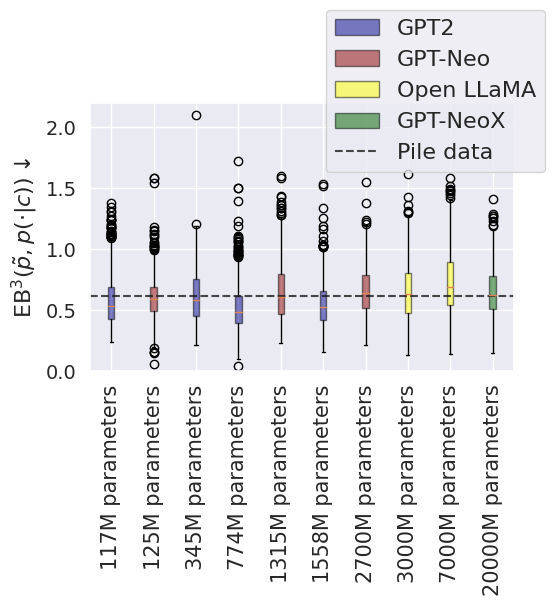

In [12]:
plt.rcParams.update({'font.size': 24})
plt.rc('axes', titlesize=24, labelsize=16)
plt.rc('ytick', labelsize=14)
plt.rc('xtick', labelsize=12)
fig, ax = plt.subplots(1, figsize=(6, 6))

ax.set_ylim([0, 2.2])
ax.set_ylabel(r'EB$^3(\tilde{p}, p(\cdot | c)) \downarrow$')
# first figure contains KL results
# kls to ground truth and pairwise are different per model size

bp1 = ax.boxplot(gpt2_EBrs[0], positions=[0], patch_artist=True, boxprops=dict(facecolor="darkblue", alpha=0.5, label='gpt2')) # labels=r'$P=$ground truth, $Q = D_i$',
bp5 = ax.boxplot(gpt_neo_EBrs[0], positions=[1], patch_artist=True, boxprops=dict(facecolor="darkred", alpha=0.5)) # labels=r'$P=$ground truth, $Q = D_i$',
bp2 = ax.boxplot(gpt2_EBrs[1], positions=[2], patch_artist=True, boxprops=dict(facecolor="darkblue", alpha=0.5)) # labels=r'$P=$ground truth, $Q = D_i$',
bp3 = ax.boxplot(gpt2_EBrs[2], positions=[3], patch_artist=True, boxprops=dict(facecolor="darkblue", alpha=0.5)) # labels=r'$P=$ground truth, $Q = D_i$',
bp6 = ax.boxplot(gpt_neo_EBrs[1], positions=[4], patch_artist=True, boxprops=dict(facecolor="darkred", alpha=0.5)) # labels=r'$P=$ground truth, $Q = D_i$',
bp4 = ax.boxplot(gpt2_EBrs[3], positions=[5], patch_artist=True, boxprops=dict(facecolor="darkblue", alpha=0.5)) # labels=r'$P=$ground truth, $Q = D_i$',
bp6 = ax.boxplot(gpt_neo_EBrs[2], positions=[6], patch_artist=True, boxprops=dict(facecolor="darkred", alpha=0.5)) # labels=r'$P=$ground truth, $Q = D_i$',
bp7 = ax.boxplot(llama_EBrs[0], positions=[7], patch_artist=True, boxprops=dict(facecolor="yellow", alpha=0.5)) # labels=r'$P=$ground truth, $Q = D_i$',
bp8 = ax.boxplot(llama_EBrs[1], positions=[8], patch_artist=True, boxprops=dict(facecolor="yellow", alpha=0.5)) # labels=r'$P=$ground truth, $Q = D_i$',
bp9 = ax.boxplot(gpt_neo_EBrs[3], positions=[9], patch_artist=True, boxprops=dict(facecolor="darkgreen", alpha=0.5)) # labels=r'$P=$ground truth, $Q = D_i$',


# uniform to ground truth is only one plot for all sizes 
# sc = ax[0].axhline(uniform_kl, c='darkred', linestyle='dashed')
l = ax.axhline(pile_EBr[0], c='k', linestyle='dashed', alpha=0.8, label='Pile data')
ax.legend([bp1['boxes'][0], bp5['boxes'][0], bp7['boxes'][0], bp9['boxes'][0], l], ['GPT2', 'GPT-Neo', 'Open LLaMA', 'GPT-NeoX', 'Pile data'], fontsize=16, bbox_to_anchor=(0.53, 0.7))

#ax.legend([bp1['whiskers'], bp2['whiskers']], ['gpt2', 'gpt2-neo'])
# ax.legend(handles=[bp1['boxes'], bp5['boxes'], bp6['boxes']], labels=['gpt2', 'gpt-neo', 'gpt-neox'])
          # , ['gpt2', 'gpt-neo', 'gpt-neox'])

ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],[f'{nr_p}M parameters' for nr_p in all_sizes], rotation=90, fontsize=15)
plt.tight_layout()

plt.savefig('images/exp2/model_sizes.pdf', bbox_inches='tight')

## Same experiment for training data (Sec. 4.4)

In [2]:
with open('../results/results_disambiguated_paper/geography_prompt_predictions_gpt-neo-125M.p', 'rb') as file:
    all_predictions_gptneosmall = pickle.load(file) # already normalised
with open('../results/results_disambiguated_paper/geography_prompt_predictions_gpt-neo-1.3B.p', 'rb') as file:
    all_predictions_gptneomedium = pickle.load(file) # already normalised
with open('../results/results_disambiguated_paper/geography_prompt_predictions_gpt-neo-2.7B.p', 'rb') as file:
    all_predictions_gptneolarge = pickle.load(file) # already normalised

# only plot GPT-NeoX in barplot
with open('../results/results_disambiguated_paper/geography_prompt_predictions_gpt-neox-20b.p', 'rb') as file:
    all_predictions_gptneox = pickle.load(file) # already normalised
    

NameError: name 'pickle' is not defined

In [14]:
gpt_neo_pile_EBrs = []

for predictions in gpt2_neo:
    ground_truth_EBr, erasure_set_sizes =  metrics.compute_metrics(predictions, pile_data_normalised, use_erasure_set=True, r=3)
    gpt_neo_pile_EBrs.append(ground_truth_EBr)

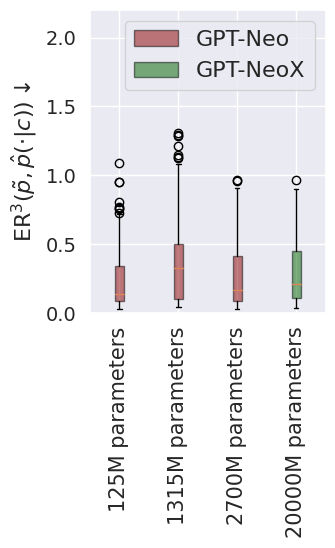

In [15]:
plt.rcParams.update({'font.size': 24})
plt.rc('axes', titlesize=24, labelsize=16)
plt.rc('ytick', labelsize=14)
plt.rc('xtick', labelsize=12)
fig, ax = plt.subplots(1, figsize=(4, 6))

ax.set_ylabel(r'ER$^3(\tilde{p}, \hat{p}(\cdot | c)) \downarrow$')
ax.set_ylim([0, 2.2])

# first figure contains KL results
# kls to ground truth and pairwise are different per model size

bp5 = ax.boxplot(gpt_neo_pile_EBrs[0], positions=[0], patch_artist=True, boxprops=dict(facecolor="darkred", alpha=0.5)) # labels=r'$P=$ground truth, $Q = D_i$',
bp6 = ax.boxplot(gpt_neo_pile_EBrs[1], positions=[1], patch_artist=True, boxprops=dict(facecolor="darkred", alpha=0.5)) # labels=r'$P=$ground truth, $Q = D_i$',
bp6 = ax.boxplot(gpt_neo_pile_EBrs[2], positions=[2], patch_artist=True, boxprops=dict(facecolor="darkred", alpha=0.5)) # labels=r'$P=$ground truth, $Q = D_i$',
bp6 = ax.boxplot(gpt_neo_pile_EBrs[3], positions=[3], patch_artist=True, boxprops=dict(facecolor="darkgreen", alpha=0.5)) # labels=r'$P=$ground truth, $Q = D_i$',


# l = ax.axhline(pile_EBr[0], c='k', linestyle='dashed', alpha=0.8, label='Pile data')
ax.legend([bp5['boxes'][0], bp6['boxes'][0]], ['GPT-Neo', 'GPT-NeoX'], fontsize=16)

#ax.legend([bp1['whiskers'], bp2['whiskers']], ['gpt2', 'gpt2-neo'])
# ax.legend(handles=[bp1['boxes'], bp5['boxes'], bp6['boxes']], labels=['gpt2', 'gpt-neo', 'gpt-neox'])
          # , ['gpt2', 'gpt-neo', 'gpt-neox'])

ax.set_xticks([0, 1, 2, 3,],[f'{nr_p}M parameters' for nr_p in gpt_neo_sizes], rotation=90, fontsize=15)
plt.tight_layout()

plt.savefig('images/exp2/model_sizes_pile.pdf',  bbox_inches='tight', pad_inches=0.)

### Predictions barplot

In [16]:
# only plot GPT-NeoX in barplot
with open('../results/results_disambiguated_paper/geography_prompt_predictions_gpt-neox-20b.p', 'rb') as file:
    all_predictions_gptneox = pickle.load(file) # already normalised

In [17]:
# 1. compute erasure bias countries determine which countries to plot
with open('../results/results_disambiguated_paper/geography_aggregated_predictions_gpt-neox-20b.p', 'rb') as file:
    aggregated_predictions_gptneox = pickle.load(file) # already normalised
EB_ground_truth_model, erasure_set = compute_metrics([aggregated_predictions_gptneox], ground_truth, use_erasure_set=True, r=3)
erasure_countries = list(erasure_set[0].keys())
erasure_countries = erasure_countries[:-3] # removing last three for better visibility
erasure_countries

['Pakistan',
 'Nigeria',
 'the Philippines',
 'Uganda',
 'Bangladesh',
 'Sri Lanka',
 'Cameroon',
 'Madagascar',
 'Papua New Guinea']

In [18]:
# top_k = 10
# top_k_countries = [item[0] for item in sorted(ground_truth_normalised.items(), key=lambda x: x[1], reverse=True)[:top_k]]
# use erasure countries instead

ix = 0
results_df = pd.DataFrame(columns=['country', 'value', 'data_source'])
for country in ground_truth:
    if country in erasure_countries:
        results_df.loc[ix, 'country'] = country
        results_df.loc[ix, 'value'] = ground_truth[country]
        results_df.loc[ix, 'data_source'] = r'$p^{true}$'
        ix += 1


for country in pile_data_normalised:
    if country in erasure_countries:
        results_df.loc[ix, 'country'] = country
        results_df.loc[ix, 'value'] = pile_data_normalised[country]
        results_df.loc[ix, 'data_source'] = r'$p^{train}$'
        ix += 1
            
for prompt_prediction in all_predictions_gptneox:
    for country in prompt_prediction:
        if country in erasure_countries:
            results_df.loc[ix, 'country'] = country
            results_df.loc[ix, 'value'] = prompt_prediction[country]
            results_df.loc[ix, 'data_source'] = r'$p$ (NeoX)'
            ix += 1
    
results_df['value'] = results_df['value'].astype(float)

['darkred', 'darkgreen', 'darkblue', 'darkred', 'darkgreen', 'darkblue', 'darkred', 'darkgreen', 'darkblue', 'darkred', 'darkgreen', 'darkblue', 'darkred', 'darkgreen', 'darkblue', 'darkred', 'darkgreen', 'darkblue', 'darkred', 'darkgreen', 'darkblue', 'darkred', 'darkgreen', 'darkblue', 'darkred', 'darkgreen', 'darkblue']


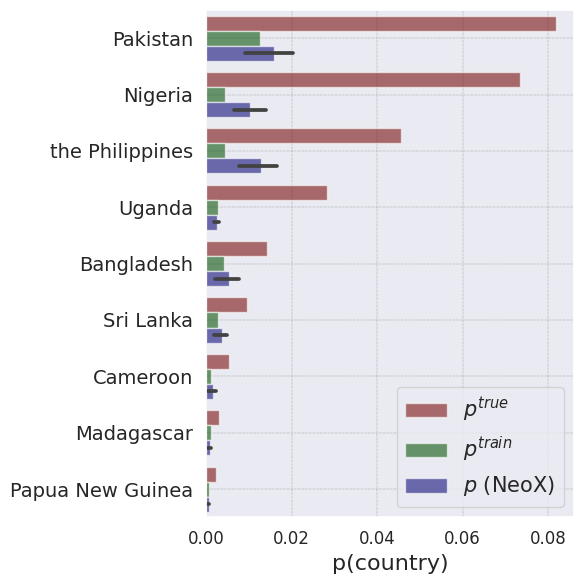

In [19]:
plt.rcParams.update({'font.size': 24})
plt.rc('axes', titlesize=24, labelsize=16)
plt.rc('ytick', labelsize=14)
plt.rc('xtick', labelsize=12)
fig, ax = plt.subplots(1, figsize=(6, 6))

cols = ['darkred', 'darkgreen', 'darkblue'] * len(erasure_countries)
print(cols)

sns.set_theme()
sns.barplot(data=results_df, x="value", y="country", hue="data_source", ax=ax, palette=cols, alpha=0.6,  errorbar=('pi', 50)) #color='darkred') 
# TODO: the algorithm by which we compute the error bars really matters here -- look into this
ax.grid(color="grey", linestyle="-.", linewidth=0.25)
ax.set(xlabel='p(country)', ylabel=None)
plt.tight_layout()
plt.legend(fontsize=15)
# plt.savefig('images/exp3/pile_barplot_erasure_set.pdf')

## All figures in one plot

['darkred', 'darkgreen', 'darkblue', 'darkred', 'darkgreen', 'darkblue', 'darkred', 'darkgreen', 'darkblue', 'darkred', 'darkgreen', 'darkblue', 'darkred', 'darkgreen', 'darkblue', 'darkred', 'darkgreen', 'darkblue', 'darkred', 'darkgreen', 'darkblue', 'darkred', 'darkgreen', 'darkblue', 'darkred', 'darkgreen', 'darkblue']


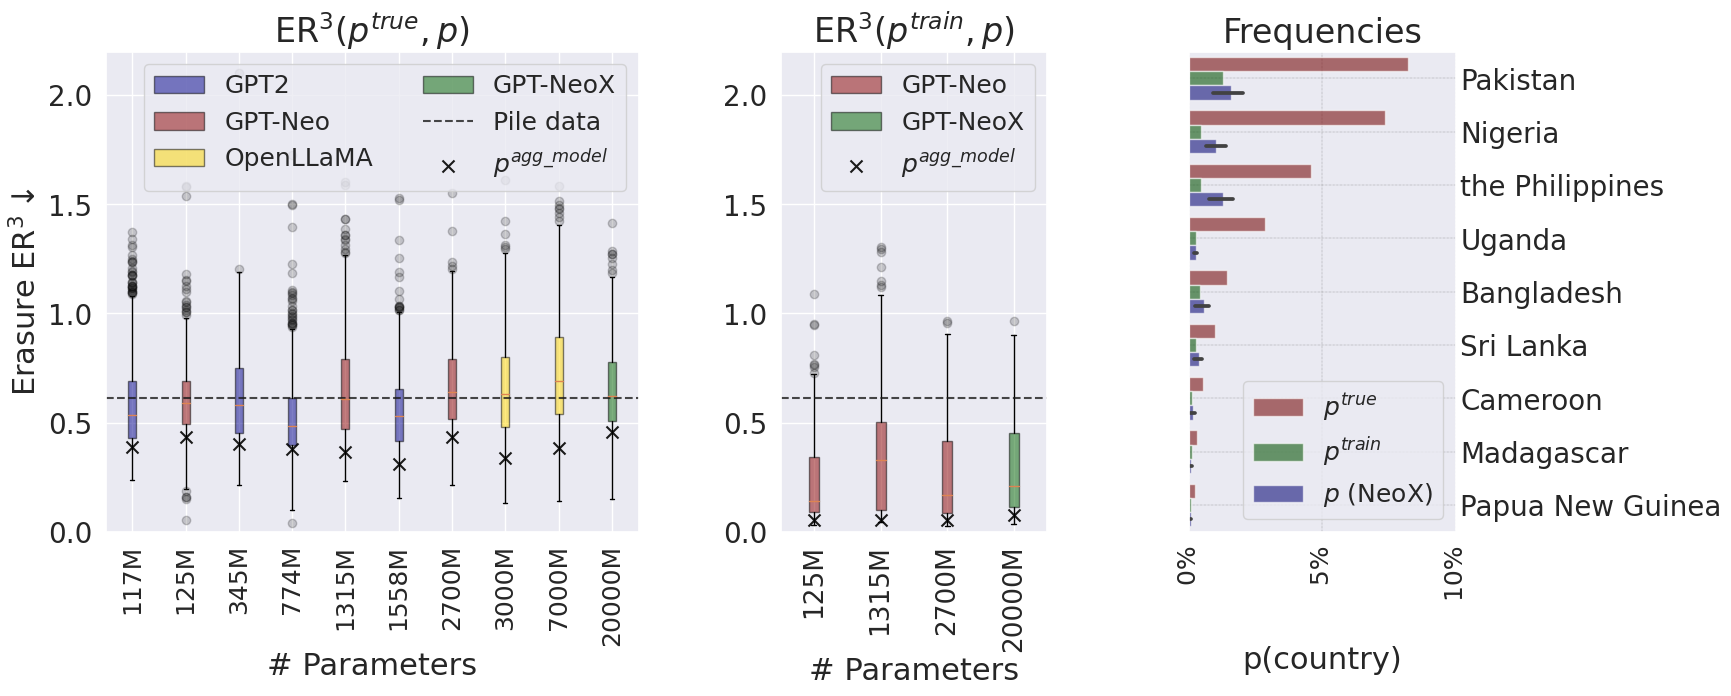

In [25]:
fig, axes = plt.subplots(1, 3, gridspec_kw={'width_ratios': [2, 1, 1]}, figsize=(15, 6))

plt.rcParams.update({'font.size': 24})
plt.rc('axes', titlesize=24, labelsize=22)
plt.rc('ytick', labelsize=20)
plt.rc('xtick', labelsize=20)

fliers = dict(markerfacecolor='k', alpha=0.2)
################### ax 1: ground truth -- models
ax = axes[0]

#ax.set_title(r'Ground Truth $\leftrightarrow$ Models')
ax.set_title(r'ER$^3(p^{true},p)$')
ax.set_ylim([0, 2.2])
ax.set_ylabel(r'Erasure ER$^3 \downarrow$')

# boxplots
bp1 = ax.boxplot(gpt2_EBrs[0], positions=[0], patch_artist=True, boxprops=dict(facecolor="darkblue", alpha=0.5, label='gpt2'), flierprops=fliers) # labels=r'$P=$ground truth, $Q = D_i$',
bp5 = ax.boxplot(gpt_neo_EBrs[0], positions=[1], patch_artist=True, boxprops=dict(facecolor="darkred", alpha=0.5), flierprops=fliers) # labels=r'$P=$ground truth, $Q = D_i$',
bp2 = ax.boxplot(gpt2_EBrs[1], positions=[2], patch_artist=True, boxprops=dict(facecolor="darkblue", alpha=0.5), flierprops=fliers) # labels=r'$P=$ground truth, $Q = D_i$',
bp3 = ax.boxplot(gpt2_EBrs[2], positions=[3], patch_artist=True, boxprops=dict(facecolor="darkblue", alpha=0.5), flierprops=fliers) # labels=r'$P=$ground truth, $Q = D_i$',
bp6 = ax.boxplot(gpt_neo_EBrs[1], positions=[4], patch_artist=True, boxprops=dict(facecolor="darkred", alpha=0.5), flierprops=fliers) # labels=r'$P=$ground truth, $Q = D_i$',
bp4 = ax.boxplot(gpt2_EBrs[3], positions=[5], patch_artist=True, boxprops=dict(facecolor="darkblue", alpha=0.5), flierprops=fliers) # labels=r'$P=$ground truth, $Q = D_i$',
bp6 = ax.boxplot(gpt_neo_EBrs[2], positions=[6], patch_artist=True, boxprops=dict(facecolor="darkred", alpha=0.5), flierprops=fliers) # labels=r'$P=$ground truth, $Q = D_i$',
bp7 = ax.boxplot(llama_EBrs[0], positions=[7], patch_artist=True, boxprops=dict(facecolor="gold", alpha=0.5), flierprops=fliers) # labels=r'$P=$ground truth, $Q = D_i$',
bp8 = ax.boxplot(llama_EBrs[1], positions=[8], patch_artist=True, boxprops=dict(facecolor="gold", alpha=0.5), flierprops=fliers) # labels=r'$P=$ground truth, $Q = D_i$',
bp9 = ax.boxplot(gpt_neo_EBrs[3], positions=[9], patch_artist=True, boxprops=dict(facecolor="darkgreen", alpha=0.5), flierprops=fliers) # labels=r'$P=$ground truth, $Q = D_i$',

# aggregated values
aggregated_vals = [aggregated_gpt2small_EBr, aggregated_gptneosmall_EBr, aggregated_gpt2medium_EBr, aggregated_gpt2large_EBr,
                   aggregated_gptneomedium_EBr, aggregated_gpt2xl_EBr, aggregated_gptneolarge_EBr, aggregated_llama3b_EBr, aggregated_llama7b_EBr, aggregated_gptneox_EBr]
scatter = ax.scatter(range(10), aggregated_vals, c='k', marker='x', s=75) # labels=r'$P=$ground truth, $Q = D_i$',

l = ax.axhline(pile_EBr[0], c='k', linestyle='dashed', alpha=0.8, label='Pile data')
ax.legend([bp1['boxes'][0], bp5['boxes'][0], bp7['boxes'][0], bp9['boxes'][0], l, scatter], 
          ['GPT2', 'GPT-Neo', 'OpenLLaMA', 'GPT-NeoX', 'Pile data', r"$p^{agg\_model}$"], fontsize=18, ncol=2) #bbox_to_anchor=(0.53, 0.7)

ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],[f'{nr_p}M' for nr_p in all_sizes], rotation=90, fontsize=18)
ax.set_xlabel('# Parameters')

################### ax 2: pile data -- models
ax = axes[1]
# x.set_title(r'Training Data $\leftrightarrow$ Models')
ax.set_title(r'ER$^3(p^{train},  p)$')
ax.set_ylim([0, 2.2])

# first figure contains KL results
# kls to ground truth and pairwise are different per model size

bp5 = ax.boxplot(gpt_neo_pile_EBrs[0], positions=[0], patch_artist=True, boxprops=dict(facecolor="darkred", alpha=0.5), flierprops=fliers) # labels=r'$P=$ground truth, $Q = D_i$',
bp6 = ax.boxplot(gpt_neo_pile_EBrs[1], positions=[1], patch_artist=True, boxprops=dict(facecolor="darkred", alpha=0.5), flierprops=fliers) # labels=r'$P=$ground truth, $Q = D_i$',
bp6 = ax.boxplot(gpt_neo_pile_EBrs[2], positions=[2], patch_artist=True, boxprops=dict(facecolor="darkred", alpha=0.5), flierprops=fliers) # labels=r'$P=$ground truth, $Q = D_i$',
bp6 = ax.boxplot(gpt_neo_pile_EBrs[3], positions=[3], patch_artist=True, boxprops=dict(facecolor="darkgreen", alpha=0.5), flierprops=fliers) # labels=r'$P=$ground truth, $Q = D_i$',

# aggregated values
aggregated_vals = [pile_aggregated_gptneosmall_EBr, pile_aggregated_gptneomedium_EBr, pile_aggregated_gptneolarge_EBr, pile_aggregated_gptneox_EBr]
scatter = ax.scatter(range(4), aggregated_vals, c='k', marker='x', s=75) # labels=r'$P=$ground truth, $Q = D_i$',

l = ax.axhline(pile_EBr[0], c='k', linestyle='dashed', alpha=0.8, label='Pile data')
ax.legend([bp5['boxes'][0], bp6['boxes'][0], scatter], ['GPT-Neo', 'GPT-NeoX', r"$p^{agg\_model}$"], fontsize=18)

ax.set_xticks([0, 1, 2, 3,],[f'{nr_p}M' for nr_p in gpt_neo_sizes], rotation=90, fontsize=19)
ax.set_xlabel('# Parameters')

# plt.savefig('images/exp2/model_sizes_pile.pdf',  bbox_inches='tight', pad_inches=0.)

################### ax 2: pile data -- models

ax = axes[2]
ax.set_title('Frequencies')
cols = ['darkred', 'darkgreen', 'darkblue'] * len(erasure_countries)
print(cols)

sns.barplot(data=results_df, x="value", y="country", hue="data_source", ax=ax, palette=cols, alpha=0.6,  errorbar=('pi', 50)) #color='darkred') 
# TODO: the algorithm by which we compute the error bars really matters here -- look into this
ax.grid(color="grey", linestyle="-.", linewidth=0.25)
ax.set(xlabel='p(country)', ylabel=None)
plt.legend(fontsize=18, loc=4)

ax.set_xticks([0, 0.05, 0.1],['     0%', '      5%', '     10%'], rotation=90, fontsize=18)

ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.tick_params(axis=u'y', which=u'both',length=0)


plt.subplots_adjust(left=0.,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
# plt.subplots_adjust(left=-1)
# plt.tight_layout()

plt.savefig('images/exp2/model_sizes_and_pile_full.pdf',  bbox_inches='tight', pad_inches=0.1)
